<a href="https://colab.research.google.com/github/jamessutton600613-png/GC/blob/main/Untitled81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

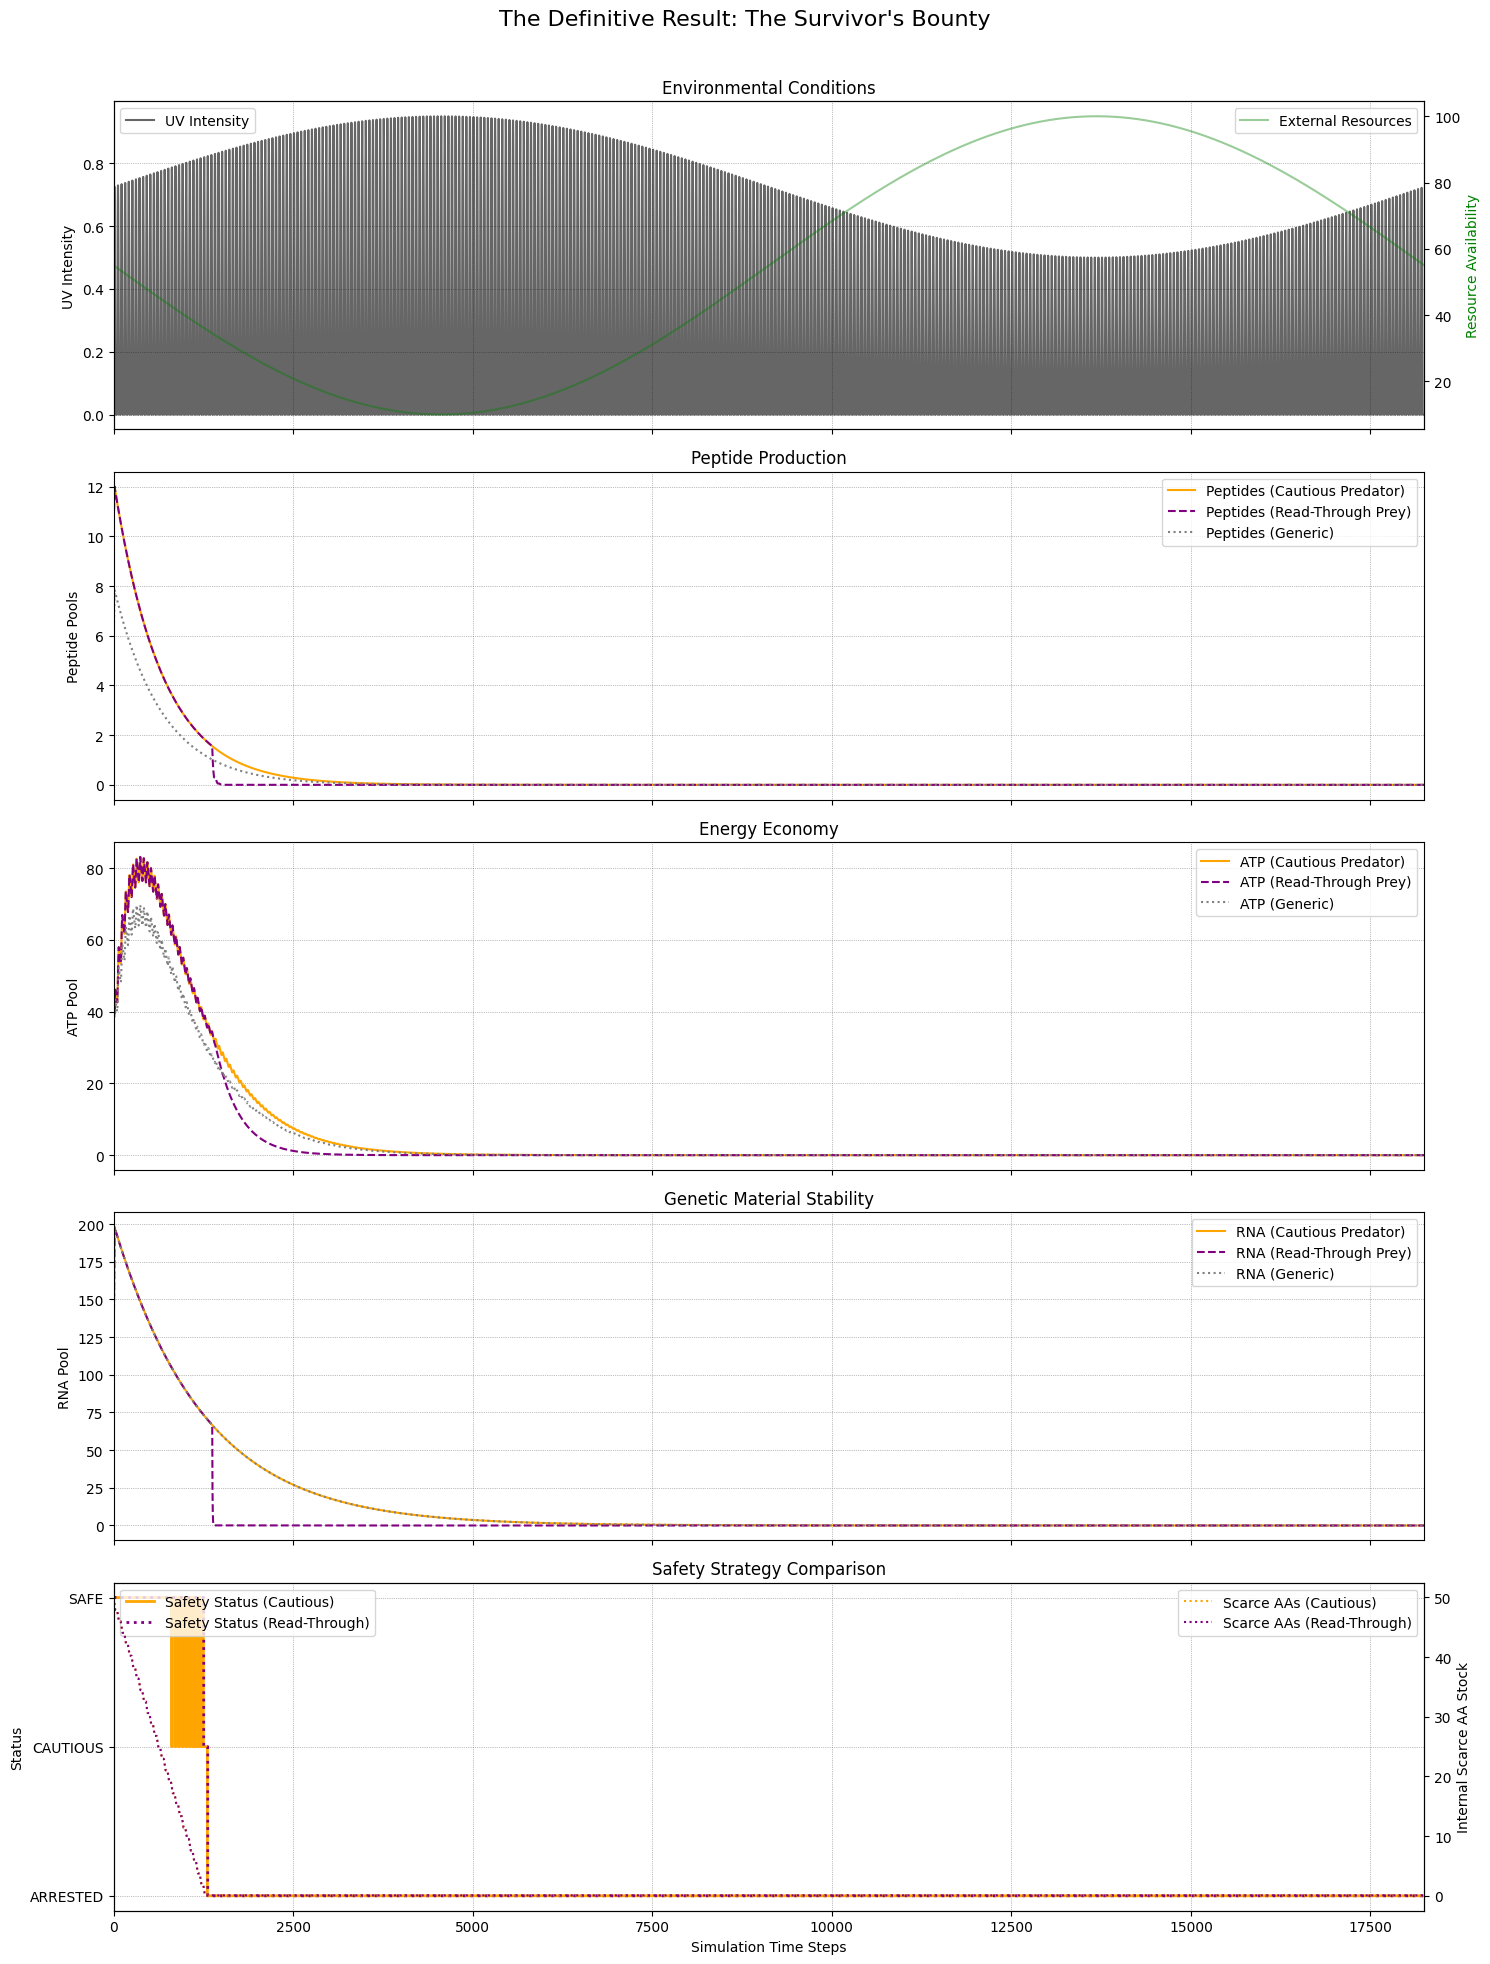

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. Environment Class with Abundant Resources ---
class Environment:
    def __init__(self, total_sim_steps, days_per_cycle=50):
        self.total_sim_steps, self.days_per_cycle, self.time = total_sim_steps, days_per_cycle, 0
        num_years = total_sim_steps / (365 * days_per_cycle)
        daily_uv_cycle = np.sin(np.linspace(0, 2 * np.pi, days_per_cycle)); daily_uv_cycle[daily_uv_cycle < 0] = 0
        seasonal_amplitude_mod = 0.225 * np.sin(np.linspace(0, 2 * np.pi * num_years, total_sim_steps)) + 0.725
        self.uv_intensity = np.array([daily_uv_cycle[i % days_per_cycle] * seasonal_amplitude_mod[i] for i in range(total_sim_steps)])

        seasonal_resource_mod = -0.45 * np.sin(np.linspace(0, 2 * np.pi * num_years, total_sim_steps)) + 0.55
        self.external_resources = 100 * seasonal_resource_mod # Abundant resources

    def get_current_uv(self):
        return self.uv_intensity[self.time] if self.time < self.total_sim_steps else 0.0

    def get_current_resources(self):
        return self.external_resources[self.time] if self.time < self.total_sim_steps else 0.0

    def step(self):
        self.time += 1

# --- 2. RNA_Peptide_Complex Class ---
class RNA_Peptide_Complex:
    def __init__(self, env, strategy='cautious'):
        self.env, self.strategy = env, strategy
        self.rna_pool, self.atp_pool = 100.0, 50.0
        self.mcyw_peptide_pool, self.other_peptide_pool = 10.0, 5.0
        self.internal_ntp_stock, self.internal_aa_stock, self.internal_trp_tyr_cys_stock = 100.0, 100.0, 50.0
        self.rna_damage_level, self.protein_synthesis_active = 0.0, True
        self.uv_safety_status, self.premature_stop_signal = "SAFE", 0.0
        self.mcyw_synthesis_bias = 0.0 if strategy == 'generic' else 0.75

        self.uv_damage_rate_per_uv = 0.15; self.repair_rate = 0.8; self.trp_tyr_cys_for_repair_needed = 0.08
        self.scavenge_efficiency = 0.6; self.premature_stop_signal_threshold = 0.20
        self.precarious_codon_rate_per_damage = 1.5; self.uv_protection_factor = 0.01; self.damage_tolerance_threshold = 4.0
        self.atp_generation_rate_per_mcyw_uv=0.15; self.repair_atp_cost=0.005
        self.protein_synthesis_rate=0.20; self.protein_synthesis_ntp_cost=0.1; self.protein_synthesis_aa_cost=0.1; self.protein_synthesis_atp_cost=0.02
        self.rna_degradation_rate=0.0008; self.peptide_degradation_rate=0.0015; self.atp_degradation_rate=0.003

    def _apply_uv_damage(self):
        uv = self.env.get_current_uv()
        if uv > 0:
            protection = self.mcyw_peptide_pool * self.uv_protection_factor
            effective_uv = uv * max(0, 1 - protection)
            damage_increase = effective_uv * self.uv_damage_rate_per_uv
            self.rna_damage_level += damage_increase
            self.premature_stop_signal = damage_increase * self.precarious_codon_rate_per_damage
        else: self.premature_stop_signal = 0

    def _manage_state(self):
        stop_signal = self.premature_stop_signal
        if self.strategy == 'readthrough': stop_signal = 0
        norm_dmg = min(1., self.rna_damage_level / self.damage_tolerance_threshold)
        scarcity = 1. - (self.internal_trp_tyr_cys_stock / 20)
        danger = (norm_dmg * 0.4) + (max(0, min(1, scarcity)) * 0.1) + (stop_signal * 0.5)
        if danger >= self.premature_stop_signal_threshold:
            self.protein_synthesis_active = False; self.uv_safety_status = "ARRESTED"
        elif danger < self.premature_stop_signal_threshold * 0.5:
            self.protein_synthesis_active = True; self.uv_safety_status = "SAFE"
        else: self.uv_safety_status = "CAUTIOUS"

    def _scavenge(self, prey):
        if self.env.get_current_uv() > 0.05 or prey.rna_damage_level < prey.damage_tolerance_threshold * 0.8: return
        scavenged_rna = prey.rna_pool * prey.rna_damage_level * self.scavenge_efficiency * 0.1
        prey.rna_pool = max(0, prey.rna_pool - scavenged_rna)
        self.internal_ntp_stock += scavenged_rna * 4
        scavenged_peptides = prey.mcyw_peptide_pool * self.scavenge_efficiency * 0.1
        prey.mcyw_peptide_pool = max(0, prey.mcyw_peptide_pool - scavenged_peptides)
        self.internal_aa_stock += scavenged_peptides * self.protein_synthesis_aa_cost
        self.internal_trp_tyr_cys_stock += scavenged_peptides * (self.protein_synthesis_aa_cost * self.mcyw_synthesis_bias)

    def _synthesize_protein(self):
        if not self.protein_synthesis_active: return
        units = self.protein_synthesis_rate
        if not (self.internal_ntp_stock >= units * self.protein_synthesis_ntp_cost and self.internal_aa_stock >= units * self.protein_synthesis_aa_cost and self.atp_pool >= units * self.protein_synthesis_atp_cost): return
        m_units = 0
        if self.mcyw_synthesis_bias > 0 and self.internal_trp_tyr_cys_stock > 0 and self.protein_synthesis_aa_cost > 0:
            m_units = min(units * self.mcyw_synthesis_bias, self.internal_trp_tyr_cys_stock / (self.protein_synthesis_aa_cost * self.mcyw_synthesis_bias))
        o_units = units - m_units
        self.mcyw_peptide_pool += m_units; self.other_peptide_pool += o_units
        if m_units > 0: self.internal_trp_tyr_cys_stock -= m_units * (self.protein_synthesis_aa_cost * self.mcyw_synthesis_bias)
        self.internal_ntp_stock -= units * self.protein_synthesis_ntp_cost
        self.internal_aa_stock -= units * self.protein_synthesis_aa_cost
        self.atp_pool -= units * self.protein_synthesis_atp_cost

    # --- NEW: RNA REPLICATION METHOD ---
    def _replicate_rna(self):
        """Replicates RNA, consuming internal NTPs and ATP."""
        # --- These parameters can be tuned ---
        replication_rate = 0.05  # Attempt to replicate 5% of the pool per step
        ntp_cost = 1.0           # 1 NTP unit needed per unit of new RNA
        atp_cost = 0.2           # 0.2 ATP units needed per unit of new RNA

        # Only replicate if the system is in an active state
        if self.protein_synthesis_active:
            # Determine how much RNA we want to create
            rna_to_create = self.rna_pool * replication_rate

            # Check if we have enough resources
            if self.internal_ntp_stock > 0 and ntp_cost > 0 and self.atp_pool > 0 and atp_cost > 0:
                # Calculate max possible replication based on each resource
                max_from_ntp = self.internal_ntp_stock / ntp_cost
                max_from_atp = self.atp_pool / atp_cost

                # The actual amount to create is the minimum of what's desired and what's possible
                actual_replication = min(rna_to_create, max_from_ntp, max_from_atp)

                if actual_replication > 0:
                    # Increase RNA pool and consume the resources
                    self.rna_pool += actual_replication
                    self.internal_ntp_stock -= actual_replication * ntp_cost
                    self.atp_pool -= actual_replication * atp_cost

    def _synthesize_atp(self):
        if self.env.get_current_uv() > 0 and self.mcyw_peptide_pool > 0: self.atp_pool += self.atp_generation_rate_per_mcyw_uv * self.mcyw_peptide_pool * self.env.get_current_uv()

    def _repair_rna_dna(self):
        if self.rna_damage_level > 0 and self.atp_pool >= self.repair_atp_cost and self.internal_trp_tyr_cys_stock >= self.trp_tyr_cys_for_repair_needed:
            self.atp_pool -= self.repair_atp_cost
            self.internal_trp_tyr_cys_stock -= self.trp_tyr_cys_for_repair_needed
            self.rna_damage_level -= min(self.rna_damage_level, self.repair_rate)

    def _degrade(self):
        for p in ['rna_pool', 'mcyw_peptide_pool', 'other_peptide_pool', 'atp_pool']:
            degradation = self.rna_degradation_rate if 'rna' in p else (self.peptide_degradation_rate if 'peptide' in p else self.atp_degradation_rate)
            setattr(self, p, getattr(self, p) * (1 - degradation))

    def step(self, prey=None):
        self._apply_uv_damage()
        self._manage_state()
        self._synthesize_atp()
        self._repair_rna_dna()
        if prey and self.strategy == 'cautious': self._scavenge(prey)
        self._synthesize_protein()
        self._replicate_rna() # --- NEW: CALLING THE REPLICATION FUNCTION ---
        self._degrade()

def run_and_plot():
    SIMULATION_DAYS = 365
    STEPS_PER_DAY = 50
    TOTAL_STEPS = SIMULATION_DAYS * STEPS_PER_DAY

    env = Environment(TOTAL_STEPS, STEPS_PER_DAY)
    complex_cautious = RNA_Peptide_Complex(env, strategy='cautious')
    complex_readthrough = RNA_Peptide_Complex(env, strategy='readthrough')
    complex_generic = RNA_Peptide_Complex(env, strategy='generic')

    data_keys = ['rna_pool', 'atp_pool', 'mcyw_peptide_pool', 'other_peptide_pool', 'rna_damage_level', 'uv_safety_status', 'internal_trp_tyr_cys_stock']
    cell_types = ['cautious', 'generic', 'readthrough']
    data = {'time': [], 'uv_intensity': [], 'external_resources': []}
    for k in data_keys:
        for c in cell_types:
            data[f'{k}_{c}'] = []

    for _ in range(TOTAL_STEPS):
        data['time'].append(env.time)
        data['uv_intensity'].append(env.get_current_uv())
        data['external_resources'].append(env.get_current_resources())

        complex_cautious.step(prey=complex_readthrough)
        complex_readthrough.step()
        complex_generic.step()

        for k in data_keys:
            for c, o in [('cautious', complex_cautious), ('generic', complex_generic), ('readthrough', complex_readthrough)]:
                data[f'{k}_{c}'].append(getattr(o, k))
        env.step()

    results_df = pd.DataFrame(data)

    fig, axs = plt.subplots(5, 1, figsize=(15, 20), sharex=True)
    fig.suptitle('The Definitive Result: The Survivor\'s Bounty', fontsize=16)
    colors = {'cautious': 'orange', 'readthrough': 'purple', 'generic': 'grey'}

    ax0_twin = axs[0].twinx()
    axs[0].plot(results_df['time'], results_df['uv_intensity'], color='black', alpha=0.6, label='UV Intensity')
    ax0_twin.plot(results_df['time'], results_df['external_resources'], color='green', alpha=0.4, label='External Resources')
    axs[0].set_title('Environmental Conditions'); axs[0].set_ylabel('UV Intensity'); ax0_twin.set_ylabel('Resource Availability', color='g')
    axs[0].legend(loc='upper left'); ax0_twin.legend(loc='upper right')

    axs[1].plot(results_df['time'], results_df['mcyw_peptide_pool_cautious'], label='Peptides (Cautious Predator)', color=colors['cautious'])
    axs[1].plot(results_df['time'], results_df['mcyw_peptide_pool_readthrough'], label='Peptides (Read-Through Prey)', color=colors['readthrough'], linestyle='--')
    axs[1].plot(results_df['time'], results_df['other_peptide_pool_generic'], label='Peptides (Generic)', color=colors['generic'], linestyle=':')
    axs[1].set_title('Peptide Production'); axs[1].set_ylabel('Peptide Pools'); axs[1].legend()

    axs[2].plot(results_df['time'], results_df['atp_pool_cautious'], label='ATP (Cautious Predator)', color=colors['cautious'])
    axs[2].plot(results_df['time'], results_df['atp_pool_readthrough'], label='ATP (Read-Through Prey)', color=colors['readthrough'], linestyle='--')
    axs[2].plot(results_df['time'], results_df['atp_pool_generic'], label='ATP (Generic)', color=colors['generic'], linestyle=':')
    axs[2].set_title('Energy Economy'); axs[2].set_ylabel('ATP Pool'); axs[2].legend()

    axs[3].plot(results_df['time'], results_df['rna_pool_cautious'], label='RNA (Cautious Predator)', color=colors['cautious'])
    axs[3].plot(results_df['time'], results_df['rna_pool_readthrough'], label='RNA (Read-Through Prey)', color=colors['readthrough'], linestyle='--')
    axs[3].plot(results_df['time'], results_df['rna_pool_generic'], label='RNA (Generic)', color=colors['generic'], linestyle=':')
    axs[3].set_title('Genetic Material Stability'); axs[3].set_ylabel('RNA Pool'); axs[3].legend()

    ax4_twin = axs[4].twinx()
    ax4_twin.plot(results_df['time'], results_df['internal_trp_tyr_cys_stock_cautious'], label='Scarce AAs (Cautious)', color=colors['cautious'], linestyle=':')
    ax4_twin.plot(results_df['time'], results_df['internal_trp_tyr_cys_stock_readthrough'], label='Scarce AAs (Read-Through)', color=colors['readthrough'], linestyle=':')
    ax4_twin.set_ylabel('Internal Scarce AA Stock')
    status_map = {"SAFE": 1, "CAUTIOUS": 0.5, "ARRESTED": 0}
    axs[4].plot(results_df['time'], results_df['uv_safety_status_cautious'].map(status_map), label='Safety Status (Cautious)', color=colors['cautious'], drawstyle='steps-post', linewidth=2)
    axs[4].plot(results_df['time'], results_df['uv_safety_status_readthrough'].map(status_map), label='Safety Status (Read-Through)', color=colors['readthrough'], linestyle=':', drawstyle='steps-post', linewidth=2)
    axs[4].set_yticks([0, 0.5, 1]); axs[4].set_yticklabels(["ARRESTED", "CAUTIOUS", "SAFE"])
    axs[4].set_title('Safety Strategy Comparison'); axs[4].set_ylabel('Status'); axs[4].legend(loc='upper left'); ax4_twin.legend(loc='upper right')

    for ax in axs:
        ax.grid(True, linestyle=':', linewidth='0.5', color='gray')
        ax.set_xlim(0, TOTAL_STEPS)

    axs[4].set_xlabel('Simulation Time Steps')
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

if __name__ == "__main__":
    run_and_plot()
